In [1]:
from google.colab import drive
drive.mount('/content/drive')
# %load_ext autoreload
# %autoreload 2
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")
from multiclass_functions2_9 import *
import torch
from torch import nn, optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/Colab Notebooks/multiclass_functions2_9.py:45: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "LR_STEP" is not None:


cuda


In [2]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3
LR_GAMMA = 0.9
EPOCH = 10
TRAIN_RATIO = 0.8
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "CNN_deep"
dataset = "STL10"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"
save_history_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt"

In [3]:
transform = transforms.ToTensor()
train_DS = datasets.STL10(root = "/content/drive/MyDrive/Colab Notebooks/data", split="train", download=True, transform=transform)
NoT = int(len(train_DS)*TRAIN_RATIO); NoV =  len(train_DS) - NoT
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])
test_DS = datasets.STL10(root = "/content/drive/MyDrive/Colab Notebooks/data", split="test", download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### 다음에 할 것: 
- 지금 있는 multiclass_function1.py에는 validation 데이터와 관련된 코드는 전무함
- 따라서, 이를 고려한 코드로 새롭게 변경할 것임

In [15]:
print(train_DS)
print(test_DS)

Dataset STL10
    Number of datapoints: 8000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: test
    StandardTransform
Transform: ToTensor()


['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
torch.Size([64, 3, 96, 96])
bird


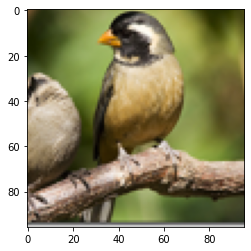

In [6]:
print(test_DS.classes)
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [7]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [8]:
model = eval(f"{model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

In [9]:
if new_model_train: # 만약 새로운 모델을 학습시키고 싶다면
    params = [p for p in model.parameters() if p.requires_grad] # for transfer learning, 즉 requires_grad가 True인 파라미터만 최적화
    optimizer = optim.Adam(params, lr=LR)

    Train(model, train_DL, val_DL, criterion, optimizer, 
          EPOCH, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path,
          LR_STEP = LR_STEP, LR_GAMMA = LR_GAMMA)

Epoch: 1, current_LR = 0.002


train loss: 14.964, val loss: 3.38126 
train acc: 14.0 %, val acc: 13.3 %, time: 8 s
--------------------
Epoch: 2, current_LR = 0.002


train loss: 3.49675, val loss: 2.31963 
train acc: 18.6 %, val acc: 23.4 %, time: 7 s
--------------------
Epoch: 3, current_LR = 0.002


train loss: 2.28299, val loss: 2.33838 
train acc: 27.1 %, val acc: 31.6 %, time: 7 s
--------------------
Epoch: 4, current_LR = 0.0018000000000000002


train loss: 1.90769, val loss: 2.25566 
train acc: 33.7 %, val acc: 33.4 %, time: 8 s
--------------------
Epoch: 5, current_LR = 0.0018000000000000002


train loss: 1.80102, val loss: 1.95844 
train acc: 37.2 %, val acc: 35.7 %, time: 8 s
--------------------
Epoch: 6, current_LR = 0.0018000000000000002


train loss: 1.65801, val loss: 1.66799 
train acc: 39.5 %, val acc: 36.5 %, time: 10 s
--------------------
Epoch: 7, current_LR = 0.0016200000000000001


train loss: 1.56238, val loss: 1.67946 
train acc: 43.5 %, val acc: 37.8 %, time: 8 s
--------------------
Epoch: 8, current_LR = 0.0016200000000000001


train loss: 1.52348, val loss: 1.62927 
train acc: 43.5 %, val acc: 40.3 %, time: 8 s
--------------------
Epoch: 9, current_LR = 0.0016200000000000001


train loss: 1.47151, val loss: 1.50651 
train acc: 46.2 %, val acc: 44.5 %, time: 8 s
--------------------
Epoch: 10, current_LR = 0.001458


train loss: 1.4003, val loss: 1.50582 
train acc: 47.9 %, val acc: 45.3 %, time: 8 s
--------------------


In [10]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]
scheduler = loaded["scheduler"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]

print(ep)
print(optimizer)
print(scheduler.step_size)
print(scheduler.gamma)

9
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.002
    lr: 0.001458
    maximize: False
    weight_decay: 0
)
3
0.9


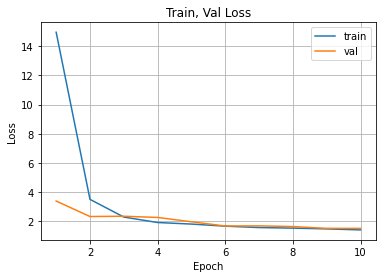

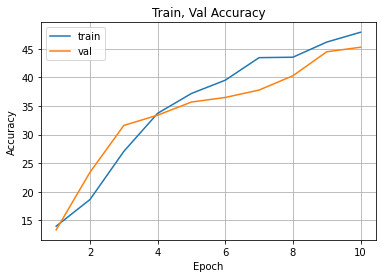

In [11]:
plt.figure()
plt.plot(range(1,EPOCH+1), loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1), loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

plt.figure()
plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.grid()
plt.legend()

In [12]:
Test(load_model, test_DL, criterion)
print(count_params(load_model))

TypeError: ignored

In [ ]:
Test_plot(load_model, test_DL)